In [1]:
# Let's first load the file to understand the structure and content of the data.
import pandas as pd

# Load the CSV file into a DataFrame
data_path = 'params_study2_retest_rt_acc.csv'
data = pd.read_csv(data_path)

# Extract the task information

# Extract the session information
data['session'] = data['Experiment'].str.extract('(part_[1-2])')

# Extract the subject ID
data['ID'] = data['Experiment'].str.extract('(\d+)_')


# Display the first few rows of the DataFrame to get an overview of the data
data.head()


,Unnamed: 0,Experiment,v1_mean,v2_mean,v3_mean,v4_mean,zr_mean,a_mean,ndt1_mean,ndt2_mean,...,alpha_mean,accuracy_percentage,mean_log_rt,RT_mean_correct_error,mean_correct,mean_Crror,error_array,RT_Cor_arr,session,ID
0,0,1010_associative_priming_part_2.dat,1.305618,0.969508,-1.733234,-1.404734,0.491254,0.870668,0.548183,0.577908,...,1.684618,0.8125,6.634323,0.773660,0.782268,0.736360,32 1.172\n48 0.790\n56 0.655\n57 ...,33 0.781\n34 0.622\n35 0.615\n36 ...,part_2,1010
1,1,2013_associative_priming_part_2.dat,1.705896,2.511653,-2.319908,-2.210795,0.482492,1.008123,0.501792,0.553702,...,1.880255,0.9050,6.533444,0.700415,0.701746,0.687737,55 0.789\n76 0.566\n81 0.646\n93 ...,32 0.859\n33 0.855\n34 0.527\n35 ...,part_2,2013
2,2,4010_associative_priming_part_2.dat,2.238770,2.390379,-2.520751,-2.576035,0.491072,1.443693,0.549831,0.530834,...,1.942024,0.9675,6.670998,0.810720,0.811044,0.801077,69 0.590\n144 0.831\n192 0.711\n224 ...,32 1.766\n33 0.950\n34 0.550\n35 ...,part_2,4010
3,3,4006_associative_priming_part_1.dat,2.218206,2.466012,-3.100036,-2.736652,0.474607,1.345451,0.490091,0.506991,...,1.718934,0.9575,6.597906,0.746932,0.751070,0.653706,36 0.913\n38 0.793\n85 0.672\n93 ...,32 0.768\n33 0.608\n34 0.808\n35 ...,part_1,4006
4,4,1001_associative_priming_part_2.dat,2.583224,2.443866,-3.785361,-3.164338,0.603328,1.267274,0.531297,0.530388,...,1.941451,0.9725,6.545834,0.710668,0.707108,0.836545,77 0.663\n81 0.607\n95 0.687\n192 ...,32 0.734\n33 0.650\n34 0.633\n35 ...,part_2,1001


In [2]:
list(data)

['Unnamed: 0',
 'Experiment',
 'v1_mean',
 'v2_mean',
 'v3_mean',
 'v4_mean',
 'zr_mean',
 'a_mean',
 'ndt1_mean',
 'ndt2_mean',
 'ndt3_mean',
 'ndt4_mean',
 'sndt_mean',
 'alpha_mean',
 'accuracy_percentage',
 'mean_log_rt',
 'RT_mean_correct_error',
 'mean_correct',
 'mean_Crror',
 'error_array',
 'RT_Cor_arr',
 'session',
 'ID']

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import chi2, shapiro

# Function to compute the Mahalanobis Distance, handling numerical issues
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Function to perform Shapiro-Wilk test and return the p-value for normality
def test_normality(data):
    _, p_value = shapiro(data)
    return p_value

# Function to process the pairs, remove outliers, and test normality
def process_pairs(data1, data2, param, p_value_threshold=0.001):
    merged_data = pd.merge(
        data1[['ID', param]],
        data2[['ID', param]],
        on='ID',
        suffixes=('_s1', '_s2')
    )
    
    bivariate_data = merged_data[[f'{param}_s1', f'{param}_s2']]
    mahalanobis_distances = safe_mahalanobis(x=bivariate_data, data=bivariate_data)
    
    threshold = chi2.ppf((1 - p_value_threshold), df=2)
    outliers = mahalanobis_distances > threshold
    cleaned_data = bivariate_data[~outliers]
    
    p_value_s1 = test_normality(cleaned_data[f'{param}_s1'])
    p_value_s2 = test_normality(cleaned_data[f'{param}_s2'])
    
    return p_value_s1, p_value_s2, outliers

# Load your data here
# data = pd.read_csv('your_data_file.csv')

# Split your data by task and session
# You will need to adapt this part to match your data structure
# For example:
ldt_session_1_data = data[(data['session'] == 'part_1')]
ldt_session_2_data = data[(data['session'] == 'part_2')]

# List of parameters to analyze
parameters = ['v1_mean',
 'v2_mean',
 'v3_mean',
 'v4_mean',
 'zr_mean',
 'a_mean',
 'ndt1_mean',
 'ndt2_mean',
 'ndt3_mean',
 'ndt4_mean',
 'sndt_mean',
 'alpha_mean',]

# Pairs of data to compare
pairs = [
    ('ldt_session_1', 'ldt_session_2'),
]

# Prepare a dictionary to store the results
results = {}

# Loop over each parameter and each pair of data
for param in parameters:
    results[param] = {}
    for pair in pairs:
        session_1_data = globals()[pair[0]+'_data']
        session_2_data = globals()[pair[1]+'_data']
        p_value_s1, p_value_s2, outliers = process_pairs(session_1_data, session_2_data, param)
        results[param][pair] = {
            'p_value_s1': p_value_s1,
            'p_value_s2': p_value_s2,
            'outliers': np.where(outliers)[0]
        }

# Print out the results
for param, data in results.items():
    print(f'Parameter: {param}')
    for pair, res in data.items():
        print(f'Data Pair: {pair}, p_value_s1: {res["p_value_s1"]}, p_value_s2: {res["p_value_s2"]}, Outliers: {res["outliers"]}')


Parameter: v1_mean
Data Pair: ('ldt_session_1', 'ldt_session_2'), p_value_s1: 0.033677469938993454, p_value_s2: 0.2584221363067627, Outliers: []
Parameter: v2_mean
Data Pair: ('ldt_session_1', 'ldt_session_2'), p_value_s1: 0.8568469882011414, p_value_s2: 0.07248596847057343, Outliers: []
Parameter: v3_mean
Data Pair: ('ldt_session_1', 'ldt_session_2'), p_value_s1: 0.2424202561378479, p_value_s2: 0.8340004086494446, Outliers: []
Parameter: v4_mean
Data Pair: ('ldt_session_1', 'ldt_session_2'), p_value_s1: 0.6693632006645203, p_value_s2: 0.765169084072113, Outliers: []
Parameter: zr_mean
Data Pair: ('ldt_session_1', 'ldt_session_2'), p_value_s1: 0.14627383649349213, p_value_s2: 0.0869721993803978, Outliers: []
Parameter: a_mean
Data Pair: ('ldt_session_1', 'ldt_session_2'), p_value_s1: 0.05399799346923828, p_value_s2: 0.04249787703156471, Outliers: []
Parameter: ndt1_mean
Data Pair: ('ldt_session_1', 'ldt_session_2'), p_value_s1: 0.5615286827087402, p_value_s2: 0.19604603946208954, Outli

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

In [4]:
import numpy as np
import pandas as pd
from scipy import stats

# Assuming you have four separate DataFrames named data_ldt_session_1, data_ldt_session_2,
# data_rmt_session_1, and data_rmt_session_2 for each dataset.

# Replace these with your actual DataFrames.
dataset = {}
# Define a function to apply arcsin and Box-Cox transformations
def apply_transformations(data, column_name):
    # Apply arcsin transformation
    data[f'{column_name}_arcsin'] = np.arcsin(np.sqrt(data[column_name] / data[column_name].max()))
    
    # Apply Box-Cox transformation
    data[f'{column_name}_boxcox_after_arcsin'], fitted_lambda = stats.boxcox(data[f'{column_name}_arcsin'])
    
    return data

# List of datasets
datasets = [ldt_session_1_data, ldt_session_2_data]

# Columns to transform
columns_to_transform = ['alpha_mean', 'accuracy_percentage']

# Apply transformations for each dataset and column
for dataset in datasets:
    for column in columns_to_transform:
        dataset = apply_transformations(dataset, column)

# Now each dataset will have 'alpha_mean_arcsin', 'alpha_mean_boxcox',
# 'accuracy_percentage_arcsin', and 'accuracy_percentage_boxcox' columns.

# You can access the transformed data as dataset['column_name_transform_type']
# For example, to access the Box-Cox transformed alpha_mean in the first dataset:
# first_dataset_boxcox = data_ldt_session_1['alpha_mean_boxcox']


In [5]:
list(ldt_session_1_data)

['Unnamed: 0',
 'Experiment',
 'v1_mean',
 'v2_mean',
 'v3_mean',
 'v4_mean',
 'zr_mean',
 'a_mean',
 'ndt1_mean',
 'ndt2_mean',
 'ndt3_mean',
 'ndt4_mean',
 'sndt_mean',
 'alpha_mean',
 'accuracy_percentage',
 'mean_log_rt',
 'RT_mean_correct_error',
 'mean_correct',
 'mean_Crror',
 'error_array',
 'RT_Cor_arr',
 'session',
 'ID',
 'alpha_mean_arcsin',
 'alpha_mean_boxcox_after_arcsin',
 'accuracy_percentage_arcsin',
 'accuracy_percentage_boxcox_after_arcsin']

In [6]:
colum = ['Experiment',
 'v1_mean',
 'v2_mean',
 'v3_mean',
 'v4_mean',
 'zr_mean',
 'a_mean',
 'ndt1_mean',
 'ndt2_mean',
 'ndt3_mean',
 'ndt4_mean',
 'sndt_mean',
 'alpha_mean',
 'accuracy_percentage',
 'mean_log_rt',
 'RT_mean_correct_error',
 'mean_correct',
 'mean_Crror',
 'error_array',
 'RT_Cor_arr',
 'session',
 'ID',
 'alpha_mean_arcsin',
 'alpha_mean_boxcox_after_arcsin',
 'accuracy_percentage_arcsin',
 'accuracy_percentage_boxcox_after_arcsin']

In [7]:
ldt_session_1_data[colum].to_csv('ldt_session_1_data_transformed.csv')
ldt_session_2_data[colum].to_csv('ldt_session_2_data_transformed.csv')


# A Step Before (see how data is normal)

In [8]:
# Function to identify outliers for all specified columns using the Mahalanobis distance
def identify_outliers(columns, session_1_data, session_2_data, alpha=0.001):
    outlier_indices_dict = {}
    
    for col in columns:
        # Extract the data for the column
        session_1_col_data = session_1_data.set_index('ID')[col]
        session_2_col_data = session_2_data.set_index('ID')[col]

        # Ensure only matching IDs are kept for comparison
        common_ids = session_1_col_data.index.intersection(session_2_col_data.index)
        paired_col_data = pd.concat([session_1_col_data.loc[common_ids], session_2_col_data.loc[common_ids]], axis=1, keys=['Session1', 'Session2'])

        # Calculate Mahalanobis distance using the safe function
        mahalanobis_dist = safe_mahalanobis(x=paired_col_data, data=paired_col_data)

        # Determine the threshold for p < alpha
        threshold = chi2.ppf((1 - alpha), df=2)  # 2 variables, as we're looking at pairs

        # Identify outliers
        outliers = mahalanobis_dist > threshold
        outlier_indices = paired_col_data.index[outliers]
        
        # Save the indices of the outliers for each column
        outlier_indices_dict[col] = outlier_indices

    return outlier_indices_dict

# Columns specified for the reliability analysis
columns_for_analysis = [
    'v1_mean',
 'v2_mean',
 'v3_mean',
 'v4_mean',
 'zr_mean',
 'a_mean',
 'ndt1_mean',
 'ndt2_mean',
 'ndt3_mean',
 'ndt4_mean',
 'sndt_mean',
 'alpha_mean',
 'accuracy_percentage',
 'mean_log_rt',
 'alpha_mean_arcsin',
 'alpha_mean_boxcox_after_arcsin',
 'accuracy_percentage_arcsin',
 'accuracy_percentage_boxcox_after_arcsin',
]

# Identify outliers for each specified column between LDT Session 1 and LDT Session 2
outliers_dict = identify_outliers(columns_for_analysis, ldt_session_1_data, ldt_session_2_data)

# Display the number of outliers for each column
outlier_counts = {col: len(indices) for col, indices in outliers_dict.items()}
outlier_counts


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 0,
 'v2_mean': 0,
 'v3_mean': 0,
 'v4_mean': 0,
 'zr_mean': 0,
 'a_mean': 0,
 'ndt1_mean': 2,
 'ndt2_mean': 1,
 'ndt3_mean': 3,
 'ndt4_mean': 1,
 'sndt_mean': 2,
 'alpha_mean': 4,
 'accuracy_percentage': 3,
 'mean_log_rt': 0,
 'alpha_mean_arcsin': 0,
 'alpha_mean_boxcox_after_arcsin': 0,
 'accuracy_percentage_arcsin': 0,
 'accuracy_percentage_boxcox_after_arcsin': 1}

In [9]:
results = []

# Loop over each parameter and each pair of data
for param in parameters:
    for pair in pairs:
        session_1_data = globals()[pair[0]+'_data']
        session_2_data = globals()[pair[1]+'_data']
        p_value_s1, p_value_s2, outliers = process_pairs(session_1_data, session_2_data, param)
        # Round the p-values to three decimal places
        p_value_s1_rounded = round(p_value_s1, 3)
        p_value_s2_rounded = round(p_value_s2, 3)
        results.append((param, pair[0], pair[1], p_value_s1_rounded, p_value_s2_rounded, np.where(outliers)[0].tolist()))

# Convert the list of tuples into a DataFrame
results_df = pd.DataFrame(results, columns=['Parameter', 'Data_Pair_1', 'Data_Pair_2', 'P_Value_S1', 'P_Value_S2', 'Outliers'])

# Show the DataFrame
print(results_df)

     Parameter    Data_Pair_1    Data_Pair_2  P_Value_S1  P_Value_S2  \
0      v1_mean  ldt_session_1  ldt_session_2       0.034       0.258   
1      v2_mean  ldt_session_1  ldt_session_2       0.857       0.072   
2      v3_mean  ldt_session_1  ldt_session_2       0.242       0.834   
3      v4_mean  ldt_session_1  ldt_session_2       0.669       0.765   
4      zr_mean  ldt_session_1  ldt_session_2       0.146       0.087   
5       a_mean  ldt_session_1  ldt_session_2       0.054       0.042   
6    ndt1_mean  ldt_session_1  ldt_session_2       0.562       0.196   
7    ndt2_mean  ldt_session_1  ldt_session_2       0.028       0.141   
8    ndt3_mean  ldt_session_1  ldt_session_2       0.204       0.845   
9    ndt4_mean  ldt_session_1  ldt_session_2       0.254       0.956   
10   sndt_mean  ldt_session_1  ldt_session_2       0.000       0.000   
11  alpha_mean  ldt_session_1  ldt_session_2       0.000       0.000   

           Outliers  
0                []  
1                []

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

In [10]:
results_df[(results_df['P_Value_S1'] > 0.05) | (results_df['P_Value_S2'] > 0.05)]

,Parameter,Data_Pair_1,Data_Pair_2,P_Value_S1,P_Value_S2,Outliers
0,v1_mean,ldt_session_1,ldt_session_2,0.034,0.258,[]
1,v2_mean,ldt_session_1,ldt_session_2,0.857,0.072,[]
2,v3_mean,ldt_session_1,ldt_session_2,0.242,0.834,[]
3,v4_mean,ldt_session_1,ldt_session_2,0.669,0.765,[]
4,zr_mean,ldt_session_1,ldt_session_2,0.146,0.087,[]
5,a_mean,ldt_session_1,ldt_session_2,0.054,0.042,[]
6,ndt1_mean,ldt_session_1,ldt_session_2,0.562,0.196,"[6, 45]"
7,ndt2_mean,ldt_session_1,ldt_session_2,0.028,0.141,[45]
8,ndt3_mean,ldt_session_1,ldt_session_2,0.204,0.845,"[11, 33, 45]"
9,ndt4_mean,ldt_session_1,ldt_session_2,0.254,0.956,[45]


In [11]:
results_df[(results_df['P_Value_S1'] < 0.05) | (results_df['P_Value_S2'] < 0.05)]

,Parameter,Data_Pair_1,Data_Pair_2,P_Value_S1,P_Value_S2,Outliers
0,v1_mean,ldt_session_1,ldt_session_2,0.034,0.258,[]
5,a_mean,ldt_session_1,ldt_session_2,0.054,0.042,[]
7,ndt2_mean,ldt_session_1,ldt_session_2,0.028,0.141,[45]
10,sndt_mean,ldt_session_1,ldt_session_2,0.000,0.000,"[12, 55]"
11,alpha_mean,ldt_session_1,ldt_session_2,0.000,0.000,"[6, 12, 33, 45]"


In [12]:
results_df[(results_df['P_Value_S1'] < 0.05) ]

,Parameter,Data_Pair_1,Data_Pair_2,P_Value_S1,P_Value_S2,Outliers
0,v1_mean,ldt_session_1,ldt_session_2,0.034,0.258,[]
7,ndt2_mean,ldt_session_1,ldt_session_2,0.028,0.141,[45]
10,sndt_mean,ldt_session_1,ldt_session_2,0.000,0.000,"[12, 55]"
11,alpha_mean,ldt_session_1,ldt_session_2,0.000,0.000,"[6, 12, 33, 45]"


In [13]:
results_df[(results_df['P_Value_S2'] < 0.05)]

,Parameter,Data_Pair_1,Data_Pair_2,P_Value_S1,P_Value_S2,Outliers
5,a_mean,ldt_session_1,ldt_session_2,0.054,0.042,[]
10,sndt_mean,ldt_session_1,ldt_session_2,0.000,0.000,"[12, 55]"
11,alpha_mean,ldt_session_1,ldt_session_2,0.000,0.000,"[6, 12, 33, 45]"


In [15]:
import pandas as pd
import numpy as np
from scipy.stats import chi2, shapiro

# Function to compute the Mahalanobis Distance, handling numerical issues
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Function to perform Shapiro-Wilk test and return the p-value for normality
def test_normality(data):
    _, p_value = shapiro(data)
    return p_value

# Function to process the pairs, remove outliers, and test normality
def process_pairs(data1, data2, param, p_value_threshold=0.001):
    merged_data = pd.merge(
        data1[['ID', param]],
        data2[['ID', param]],
        on='ID',
        suffixes=('_s1', '_s2')
    )
    
    bivariate_data = merged_data[[f'{param}_s1', f'{param}_s2']]
    mahalanobis_distances = safe_mahalanobis(x=bivariate_data, data=bivariate_data)
    
    threshold = chi2.ppf((1 - p_value_threshold), df=2)
    outliers = mahalanobis_distances > threshold
    cleaned_data = bivariate_data[~outliers]
    
    p_value_s1 = test_normality(cleaned_data[f'{param}_s1'])
    p_value_s2 = test_normality(cleaned_data[f'{param}_s2'])
    
    return p_value_s1, p_value_s2, outliers

# Load your data here
data = pd.read_csv('your_data_file.csv')

# Split your data by task and session
# You will need to adapt this part to match your data structure
# For example:
ldt_session_1_data = data[(data['session'] == 'part_1')]
ldt_session_2_data = data[(data['session'] == 'part_2')]

# List of parameters to analyze
parameters = ['v1_mean',
 'v2_mean',
 'v3_mean',
 'v4_mean',
 'zr_mean',
 'a_mean',
 'ndt1_mean',
 'ndt2_mean',
 'ndt3_mean',
 'ndt4_mean',
 'sndt_mean',
 'alpha_mean',
 'accuracy_percentage',
 'mean_log_rt',
 'alpha_mean_arcsin',
 'alpha_mean_boxcox_after_arcsin',
 'accuracy_percentage_arcsin',
 'accuracy_percentage_boxcox_after_arcsin',
 'session'           
             ]

# Pairs of data to compare
pairs = [
    ('ldt_session_1', 'ldt_session_2'),
    
]

# Prepare a dictionary to store the results
results = {}

# Loop over each parameter and each pair of data
for param in parameters:
    results[param] = {}
    for pair in pairs:
        session_1_data = globals()[pair[0]+'_data']
        session_2_data = globals()[pair[1]+'_data']
        p_value_s1, p_value_s2, outliers = process_pairs(session_1_data, session_2_data, param)
        results[param][pair] = {
            'p_value_s1': p_value_s1,
            'p_value_s2': p_value_s2,
            'outliers': np.where(outliers)[0]
        }

# Print out the results
for param, data in results.items():
    print(f'Parameter: {param}')
    for pair, res in data.items():
        print(f'Data Pair: {pair}, p_value_s1: {res["p_value_s1"]}, p_value_s2: {res["p_value_s2"]}, Outliers: {res["outliers"]}')


FileNotFoundError: [Errno 2] No such file or directory: 'your_data_file.csv'

In [16]:
# We will now perform Shapiro-Wilk tests separately for each parameter within each of the four tasks.
shapiro_results_tasks = {}

# List of task datasets for convenience
task_datasets = {
    'LDT_Part_1': ldt_part_1_data,
    'LDT_Part_2': ldt_part_2_data,
    'RMT_Part_1': rmt_part_1_data,
    'RMT_Part_2': rmt_part_2_data
}

# Apply Shapiro-Wilk test for each parameter within each task
for task_name, task_data in task_datasets.items():
    shapiro_results_tasks[task_name] = {}
    for param in parameters:
        # Perform Shapiro-Wilk test and store the results
        shapiro_stat, shapiro_p = shapiro(task_data[param].dropna())
        shapiro_results_tasks[task_name][param] = {'Statistic': shapiro_stat, 'p-value': shapiro_p}

# Convert the results to a DataFrame for better readability
results_df = pd.DataFrame.from_dict({(i, j): shapiro_results_tasks[i][j]
                                             for i in shapiro_results_tasks.keys()
                                             for j in shapiro_results_tasks[i].keys()},
                                            orient='index')

results_df


NameError: name 'ldt_part_1_data' is not defined

In [37]:
results = []

# Loop over each parameter and each pair of data
for param in parameters:
    for pair in pairs:
        session_1_data = globals()[pair[0]+'_data']
        session_2_data = globals()[pair[1]+'_data']
        p_value_s1, p_value_s2, outliers = process_pairs(session_1_data, session_2_data, param)
        # Round the p-values to three decimal places
        p_value_s1_rounded = round(p_value_s1, 3)
        p_value_s2_rounded = round(p_value_s2, 3)
        results.append((param, pair[0], pair[1], p_value_s1_rounded, p_value_s2_rounded, np.where(outliers)[0].tolist()))

# Convert the list of tuples into a DataFrame
results_df = pd.DataFrame(results, columns=['Parameter', 'Data_Pair_1', 'Data_Pair_2', 'P_Value_S1', 'P_Value_S2', 'Outliers'])

# Show the DataFrame
print(results_df)

     Parameter    Data_Pair_1    Data_Pair_2  P_Value_S1  P_Value_S2  \
0      v1_mean  ldt_session_1  ldt_session_2       0.039       0.502   
1      v1_mean  ldt_session_1  rmt_session_1       0.070       0.435   
2      v1_mean  ldt_session_2  rmt_session_2       0.491       0.289   
3      v1_mean  rmt_session_1  rmt_session_2       0.449       0.403   
4      v2_mean  ldt_session_1  ldt_session_2       0.055       0.052   
5      v2_mean  ldt_session_1  rmt_session_1       0.054       0.009   
6      v2_mean  ldt_session_2  rmt_session_2       0.078       0.011   
7      v2_mean  rmt_session_1  rmt_session_2       0.008       0.011   
8      zr_mean  ldt_session_1  ldt_session_2       0.118       0.299   
9      zr_mean  ldt_session_1  rmt_session_1       0.166       0.061   
10     zr_mean  ldt_session_2  rmt_session_2       0.490       0.039   
11     zr_mean  rmt_session_1  rmt_session_2       0.061       0.030   
12      a_mean  ldt_session_1  ldt_session_2       0.754       0

In [38]:
results_df[(results_df['P_Value_S1'] > 0.05) | (results_df['P_Value_S2'] > 0.05)]

,Parameter,Data_Pair_1,Data_Pair_2,P_Value_S1,P_Value_S2,Outliers
0,v1_mean,ldt_session_1,ldt_session_2,0.039,0.502,[]
1,v1_mean,ldt_session_1,rmt_session_1,0.070,0.435,[61]
2,v1_mean,ldt_session_2,rmt_session_2,0.491,0.289,[]
3,v1_mean,rmt_session_1,rmt_session_2,0.449,0.403,[63]
4,v2_mean,ldt_session_1,ldt_session_2,0.055,0.052,"[2, 40]"
5,v2_mean,ldt_session_1,rmt_session_1,0.054,0.009,[2]
6,v2_mean,ldt_session_2,rmt_session_2,0.078,0.011,[]
8,zr_mean,ldt_session_1,ldt_session_2,0.118,0.299,[40]
9,zr_mean,ldt_session_1,rmt_session_1,0.166,0.061,[]
10,zr_mean,ldt_session_2,rmt_session_2,0.490,0.039,[32]


In [40]:
results_df[(results_df['P_Value_S1'] > 0.05) & (results_df['P_Value_S2'] > 0.05)]

,Parameter,Data_Pair_1,Data_Pair_2,P_Value_S1,P_Value_S2,Outliers
1,v1_mean,ldt_session_1,rmt_session_1,0.070,0.435,[61]
2,v1_mean,ldt_session_2,rmt_session_2,0.491,0.289,[]
3,v1_mean,rmt_session_1,rmt_session_2,0.449,0.403,[63]
4,v2_mean,ldt_session_1,ldt_session_2,0.055,0.052,"[2, 40]"
8,zr_mean,ldt_session_1,ldt_session_2,0.118,0.299,[40]
9,zr_mean,ldt_session_1,rmt_session_1,0.166,0.061,[]
16,ndt_mean,ldt_session_1,ldt_session_2,0.328,0.188,[1]


In [41]:
results_df[(results_df['P_Value_S1'] < 0.05) & (results_df['P_Value_S2'] < 0.05)]

,Parameter,Data_Pair_1,Data_Pair_2,P_Value_S1,P_Value_S2,Outliers
7,v2_mean,rmt_session_1,rmt_session_2,0.008,0.011,[]
13,a_mean,ldt_session_1,rmt_session_1,0.014,0.003,[]
20,sndt_mean,ldt_session_1,ldt_session_2,0.000,0.000,"[63, 89, 100]"
21,sndt_mean,ldt_session_1,rmt_session_1,0.000,0.002,[89]
22,sndt_mean,ldt_session_2,rmt_session_2,0.000,0.000,"[16, 28, 73]"
23,sndt_mean,rmt_session_1,rmt_session_2,0.002,0.000,[52]
24,alpha_mean,ldt_session_1,ldt_session_2,0.000,0.000,"[1, 19, 42]"
25,alpha_mean,ldt_session_1,rmt_session_1,0.000,0.000,"[19, 42]"
26,alpha_mean,ldt_session_2,rmt_session_2,0.000,0.000,"[21, 45, 56]"
27,alpha_mean,rmt_session_1,rmt_session_2,0.000,0.000,"[81, 100]"


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


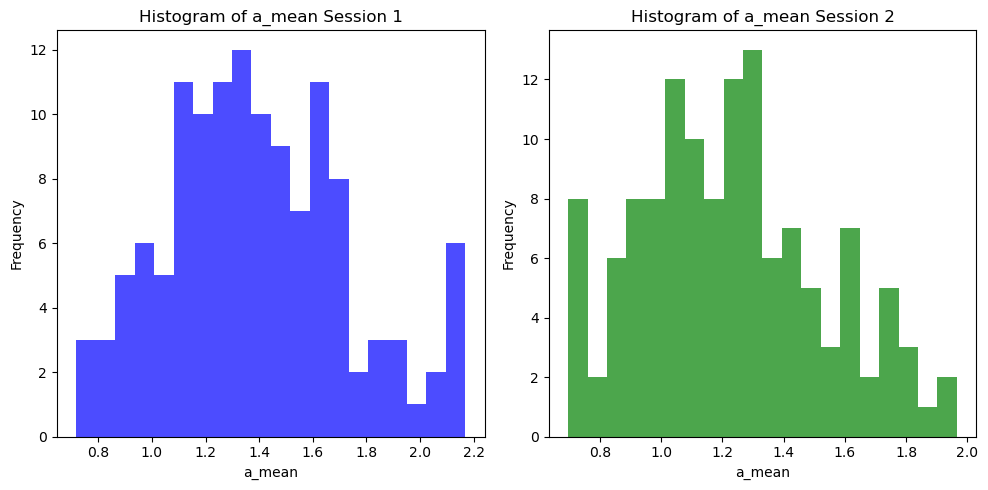

In [23]:
import pandas as pd
import numpy as np
from scipy.stats import chi2, shapiro
import matplotlib.pyplot as plt

# Assuming 'a_mean' is the parameter of interest

# Function to compute the Mahalanobis Distance, handling numerical issues
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Function to perform Shapiro-Wilk test and return the p-value for normality
def test_normality(data):
    _, p_value = shapiro(data)
    return p_value

# Function to process the pairs, remove outliers, and test normality
def process_pairs(data1, data2, param, p_value_threshold=0.001):
    merged_data = pd.merge(
        data1[['ID', param]],
        data2[['ID', param]],
        on='ID',
        suffixes=('_s1', '_s2')
    )
    
    bivariate_data = merged_data[[f'{param}_s1', f'{param}_s2']]
    mahalanobis_distances = safe_mahalanobis(x=bivariate_data, data=bivariate_data)
    
    threshold = chi2.ppf((1 - p_value_threshold), df=2)
    outliers = mahalanobis_distances > threshold
    cleaned_data = bivariate_data[~outliers]
    
    p_value_s1 = test_normality(cleaned_data[f'{param}_s1'])
    p_value_s2 = test_normality(cleaned_data[f'{param}_s2'])
    
    return cleaned_data, p_value_s1, p_value_s2

# Load your data here
#data = pd.read_csv('your_data_file.csv')

# Split your data by task and session
# You will need to adapt this part to match your data structure
# For example:
# ldt_session_1_data = data[(data['task'] == 'LDT') & (data['session'] == 1)]
# ldt_session_2_data = data[(data['task'] == 'LDT') & (data['session'] == 2)]
# rmt_session_1_data = data[(data['task'] == 'RMT') & (data['session'] == 1)]
# rmt_session_2_data = data[(data['task'] == 'RMT') & (data['session'] == 2)]

# Define the parameter of interest
param = 'a_mean'

# Define the session data placeholders (replace with actual session data)
session_1_data_ldt = ldt_session_1_data
session_2_data_ldt = ldt_session_2_data



# Process the pairs and get the cleaned data without outliers
cleaned_data_ldt, p_value_s1_ldt, p_value_s2_ldt = process_pairs(session_1_data_ldt, session_2_data_ldt, param)

# Plot the cleaned data
plt.figure(figsize=(10, 5))

# Plot session 1
plt.subplot(1, 2, 1)
plt.hist(cleaned_data_ldt[f'{param}_s1'], bins=20, alpha=0.7, color='blue')
plt.title('Histogram of a_mean Session 1')
plt.xlabel('a_mean')
plt.ylabel('Frequency')

# Plot session 2
plt.subplot(1, 2, 2)
plt.hist(cleaned_data_ldt[f'{param}_s2'], bins=20, alpha=0.7, color='green')
plt.title('Histogram of a_mean Session 2')
plt.xlabel('a_mean')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()


In [25]:
cleaned_data_ldt

,a_mean_s1,a_mean_s2
0,1.345451,1.416487
1,1.486214,1.439859
2,1.337360,1.107070
3,1.370341,0.867096
4,1.117492,0.946552
...,...,...
123,1.862562,1.472839
124,1.142390,1.027249
125,1.732084,1.305986
126,1.005151,1.073359


NameError: name 'cleaned_data_rmt' is not defined

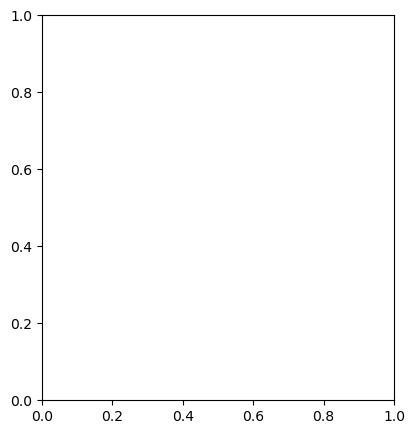

In [24]:
# Plot the cleaned data
plt.figure(figsize=(10, 5))

# Plot session 1
plt.subplot(1, 2, 1)
plt.hist(cleaned_data_rmt[f'{param}_s1'], bins=20, alpha=0.7, color='blue')
plt.title('Histogram of a_mean Session 1')
plt.xlabel('a_mean')
plt.ylabel('Frequency')

# Plot session 2
plt.subplot(1, 2, 2)
plt.hist(cleaned_data_rmt[f'{param}_s2'], bins=20, alpha=0.7, color='green')
plt.title('Histogram of a_mean Session 2')
plt.xlabel('a_mean')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()


In [47]:
cleaned_data_rmt

,a_mean_s1,a_mean_s2
0,0.807983,0.780216
1,1.469930,1.536894
2,1.372681,1.038550
3,1.358417,1.284601
4,1.701428,1.738707
...,...,...
98,0.821679,0.907188
99,1.673161,1.805013
100,1.421182,1.637280
101,1.604952,1.241112


Transformed Alpha P-Value for Normality: 0.5455845594406128
Box-Cox Transformation Lambda: 3.5191454393625694


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


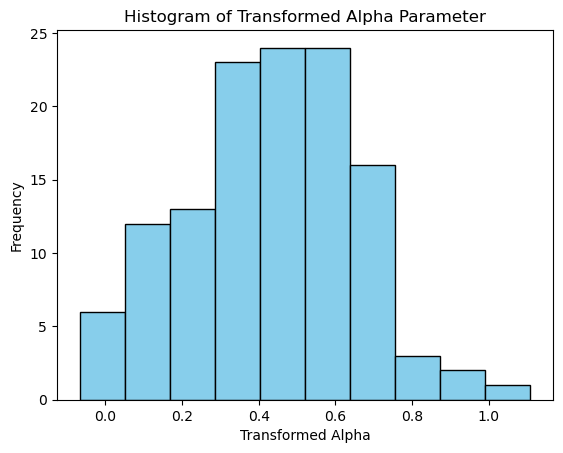

In [27]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Function to perform Shapiro-Wilk test and return the p-value for normality
def test_normality(data):
    _, p_value = shapiro(data)
    return p_value


param = 'alpha_mean'

# Define the session data placeholders (replace with actual session data)
session_1_data_ldt = ldt_session_1_data
session_2_data_ldt = ldt_session_2_data



# Process the pairs and get the cleaned data without outliers
cleaned_alpha_data, p_value_s1_ldt, p_value_s2_ldt = process_pairs(session_1_data_ldt, session_2_data_ldt, param)


# Assuming the outliers have been removed and we have the cleaned data in cleaned_data DataFrame
# Replace 'cleaned_data' and 'alpha_mean' with your actual DataFrame and column names

# Remove any non-positive values because Box-Cox requires all positive data
# Note: The arcsine square root transformation is only applicable to data in the range [0, 1].
# If your data does not fall within this range, you may need to normalize it first or choose a different transformation.
#cleaned_alpha_data = cleaned_data[cleaned_data['alpha_mean'] > 0]

# Apply the arcsin square root transformation
# Ensuring the data is within the bounds by dividing by the max, if necessary
max_alpha = cleaned_alpha_data['alpha_mean_s2'].max()
cleaned_alpha_data['alpha_arcsin'] = np.arcsin(np.sqrt(cleaned_alpha_data['alpha_mean_s2'] / max_alpha))

# Apply the Box-Cox transformation
cleaned_alpha_data['alpha_boxcox'], fitted_lambda = stats.boxcox(cleaned_alpha_data['alpha_arcsin'])

# Check the normality of the transformed data
transformed_alpha_p_value = test_normality(cleaned_alpha_data['alpha_boxcox'])

# Output the p-value and lambda
print(f"Transformed Alpha P-Value for Normality: {transformed_alpha_p_value}")
print(f"Box-Cox Transformation Lambda: {fitted_lambda}")

# Plot the histogram of the transformed alpha data
plt.hist(cleaned_alpha_data['alpha_boxcox'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Transformed Alpha Parameter')
plt.xlabel('Transformed Alpha')
plt.ylabel('Frequency')
plt.show()


In [56]:
 cleaned_alpha_data_rmt

,alpha_mean_s1,alpha_mean_s2
0,1.707921,1.825903
1,1.850396,1.943367
2,1.925421,1.847589
3,1.916706,1.823412
4,1.926442,1.814769
...,...,...
97,1.884140,1.813831
98,1.903438,1.889694
99,1.826307,1.852495
101,1.809162,1.854509


Log-Transformed Alpha P-Value for Normality: 0.000202929149963893


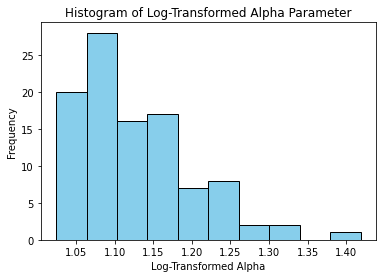

In [61]:

# Assuming 'cleaned_data' is your DataFrame and it has been loaded and cleaned to remove outliers
# and 'alpha_mean' is the column of interest.

# Replace 'cleaned_data' and 'alpha_mean' with the actual DataFrame and column name

# Reflect the alpha data by subtracting from a constant larger than the maximum value of the range
# Since the range of alpha is [1, 2], we can subtract from a constant such as 3.
reflected_alpha = 3 - cleaned_alpha_data_rmt['alpha_mean_s1']

# Apply the log transformation to the reflected data
cleaned_alpha_data_rmt['alpha_log'] = np.log(reflected_alpha)

# Test for normality of the log-transformed data
transformed_alpha_p_value = shapiro(cleaned_alpha_data_rmt['alpha_log'])[1]

# Output the p-value
print(f"Log-Transformed Alpha P-Value for Normality: {transformed_alpha_p_value}")

# Plot the histogram of the log-transformed alpha data
plt.hist(cleaned_data['alpha_log'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Log-Transformed Alpha Parameter')
plt.xlabel('Log-Transformed Alpha')
plt.ylabel('Frequency')
plt.show()


In [53]:
cleaned_alpha_data

,alpha_mean_s1,alpha_mean_s2,alpha_arcsin,alpha_boxcox
0,1.930676,1.845076,1.320463,0.389509
2,1.624799,1.788918,1.266213,0.313629
3,1.900512,1.842451,1.317695,0.385536
4,1.859360,1.795960,1.272532,0.322253
5,1.984089,1.912572,1.405634,0.517086
...,...,...,...,...
99,1.895326,1.502782,1.064108,0.066805
100,1.899358,1.653850,1.161125,0.178326
101,1.975318,1.886097,1.368166,0.459682
102,1.773389,1.486006,1.054113,0.056033
